In [1]:
import collections
collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
# load dataset
dataset = Dataset(dataset_dir="../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/dataset/", augmentation=get_training_augmentation())

D:\anaconda\envs\segmentation_gpu\lib\site-packages\albumentations\augmentations\transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


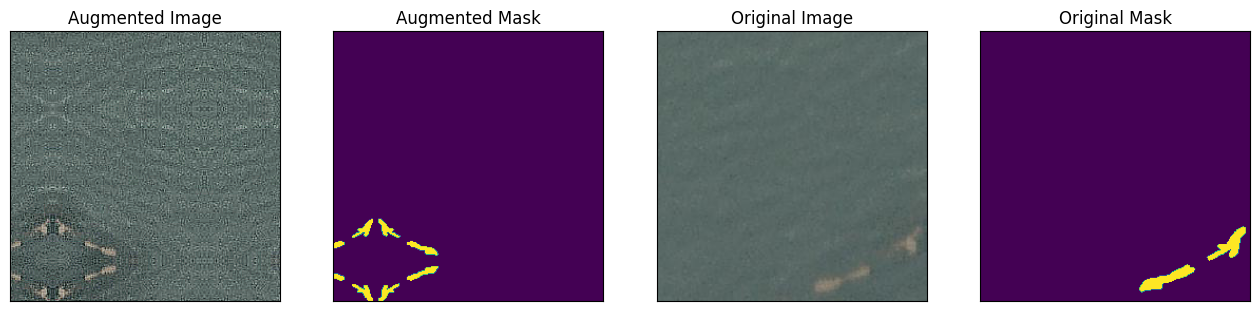

In [6]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

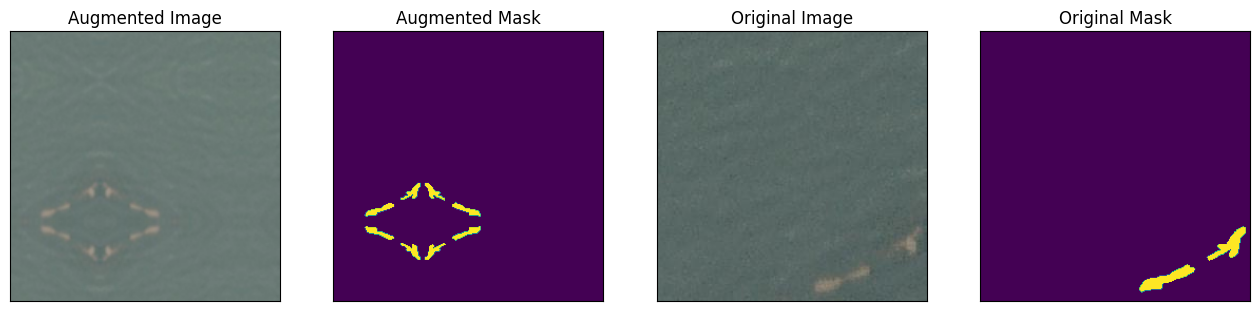

In [7]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

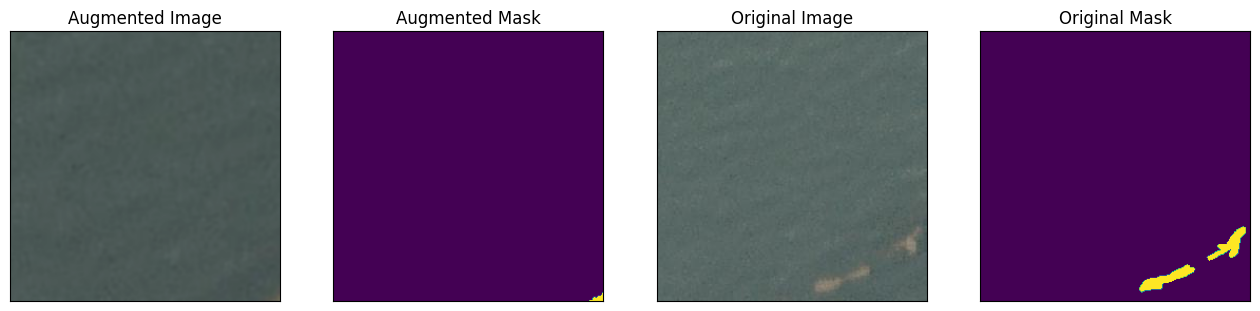

In [8]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

In [9]:
with tf.device('/GPU:0'):
    # train test split
    x_train, x_val, y_train, y_val = dataset.split_data()

    # pre processing
    x_train, y_train, x_val, y_val = dataset.pre_process(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

    # define dataloader and datasets objects for train and validation data
    train_dataset = Dataset(
        x=x_train,
        y=y_train,
        augmentation=get_training_augmentation()
    )

    valid_dataset = Dataset(
        x=x_val,
        y=y_val,
        augmentation=get_training_augmentation()
    )

In [10]:
train_dataloader = Dataloader(train_dataset, batch_size=8, shuffle=True, generate=10)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False, generate=5)

In [11]:
with tf.device('/GPU:0'):
    BACKBONE = 'inceptionresnetv2'
    BATCH_SIZE = 8
    EPOCHS = 30

    preprocess_input = sm.get_preprocessing(BACKBONE)
    # define network parameters
    n_classes = 1
    activation = 'sigmoid'

    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    # dice loss = 1 - (2 * intersection) / (union + intersection)
    dice_loss = sm.losses.DiceLoss()
    # Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
    # α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
    # p is the predicted probability of the positive class.
    # γ is the focusing parameter that controls how much the loss is focused on hard examples.
    # When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
    # the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
    focal_loss = sm.losses.BinaryFocalLoss(gamma=2.5, alpha=0.3)

    total_loss = dice_loss + 1.5*focal_loss

    metrics = [sm.metrics.IOUScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
    # define callbacks for learning rate scheduling and best checkpoints saving
    callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model_inceptionresnetv2_1.h5', save_weights_only=True, save_best_only=True, mode='min', monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(),
    ]
    tf.config.run_functions_eagerly(True)
    history = model.fit(
    x=train_dataloader.dataset.x,
    y=train_dataloader.dataset.y,
    shuffle=train_dataloader.shuffle,
    batch_size=train_dataloader.batch_size,
    callbacks=callbacks,
    epochs=EPOCHS,
    validation_data=(valid_dataloader.dataset.x, valid_dataloader.dataset.y),
    )

C:\Users\AvivL\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
200/200 [==============================] - 173s 832ms/step - loss: 0.4623 - iou_score: 0.5562 - val_loss: 0.5784 - val_iou_score: 0.3198 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 155s 777ms/step - loss: 0.1936 - iou_score: 0.7153 - val_loss: 0.6003 - val_iou_score: 0.2954 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 164s 821ms/step - loss: 0.1664 - iou_score: 0.7485 - val_loss: 0.3772 - val_iou_score: 0.4997 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 159s 796ms/step - loss: 0.1461 - iou_score: 0.7757 - val_loss: 0.3725 - val_iou_score: 0.5025 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 156s 780ms/step - loss: 0.1196 - iou_score: 0.8121 - val_loss: 0.3318 - val_iou_score: 0.5418 - lr: 0.0010
Epoch 6/30
200/200 [==============================] - 155s 774ms/step - loss: 0.1033 - iou_score: 0.8356 - val_loss: 0.3367 - val_iou_score: 0.5393 - lr: 0.0010
Epoch 7/30
200/200 [==============

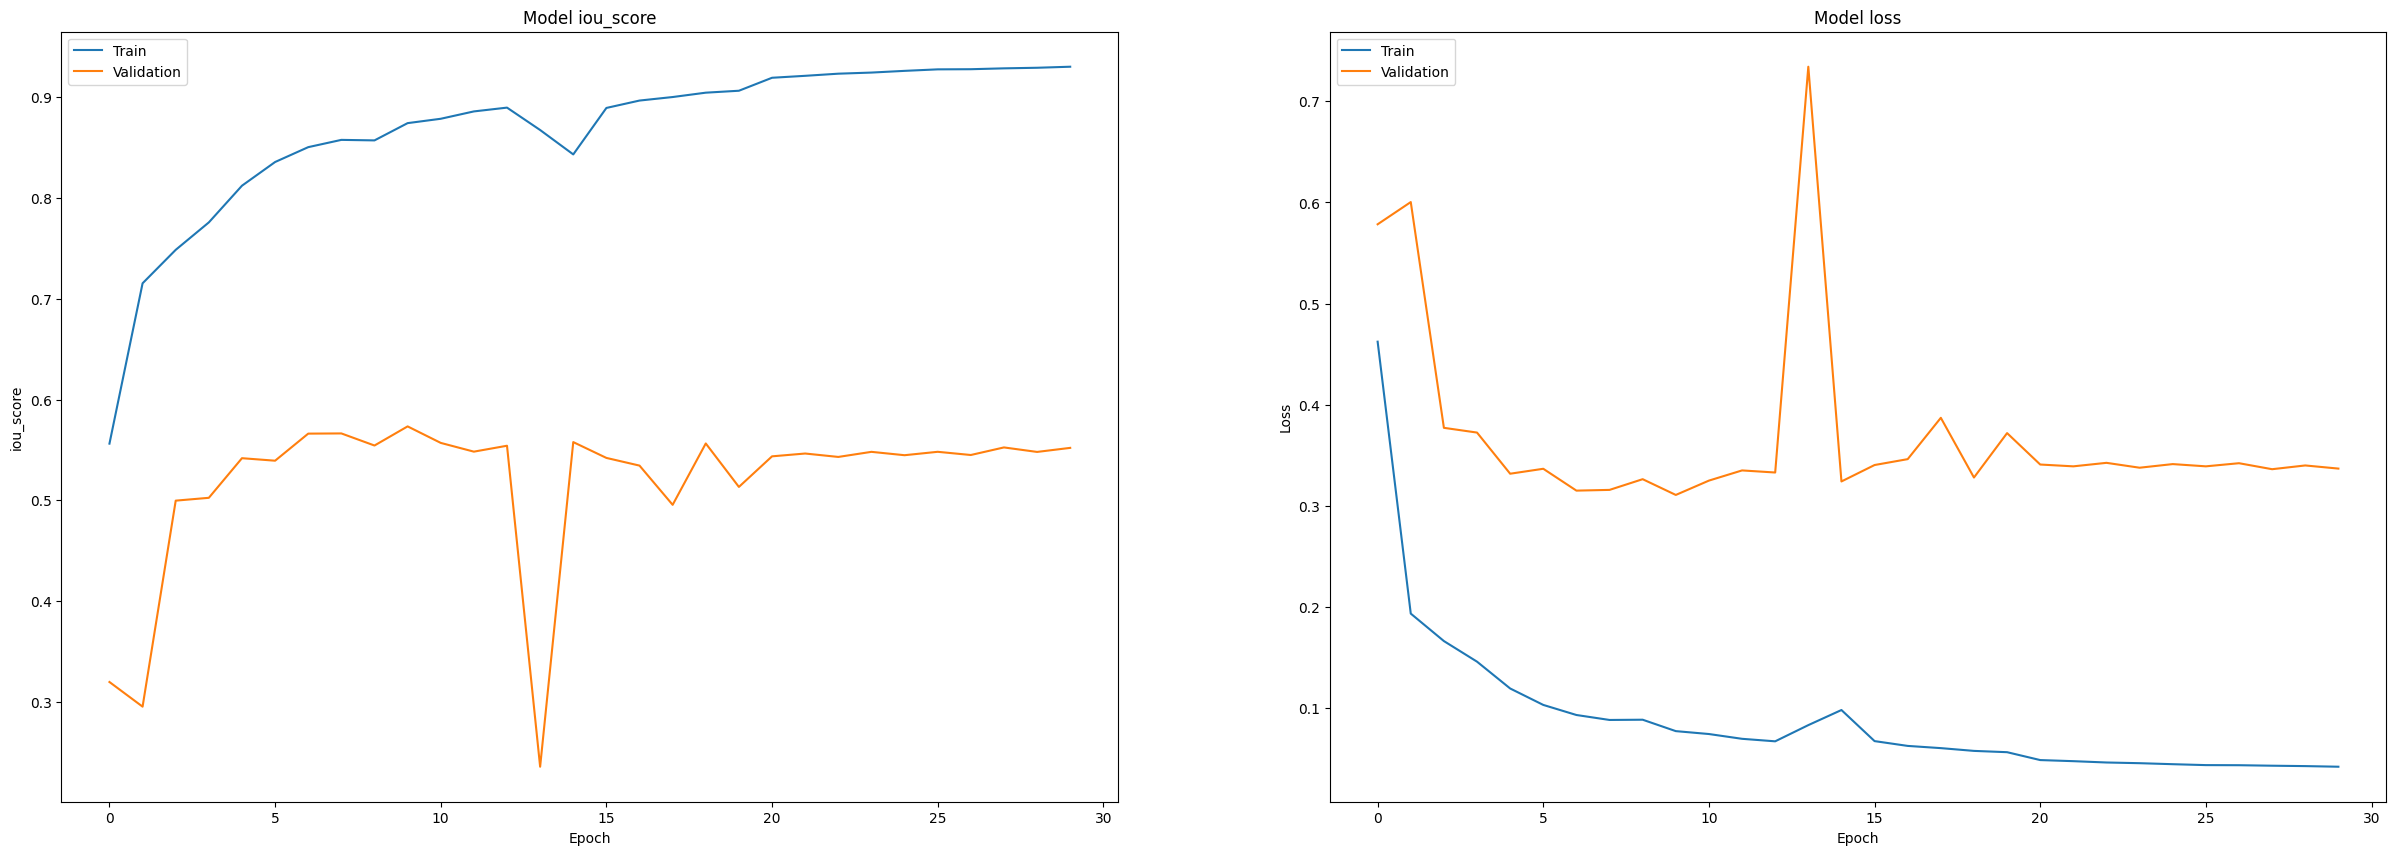

In [12]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
model.load_weights("best_model_inceptionresnetv2_1.h5")

1/1 [==============================] - 1s 1s/step


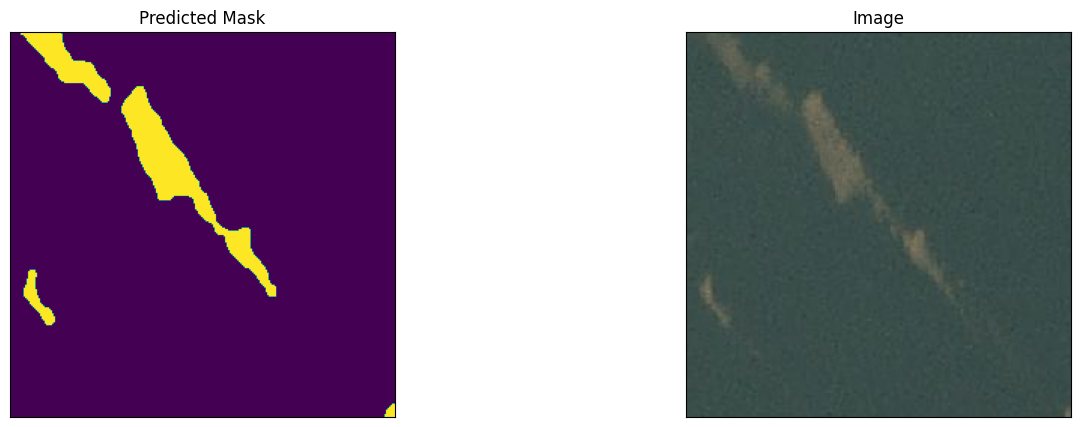

1/1 [==============================] - 0s 348ms/step


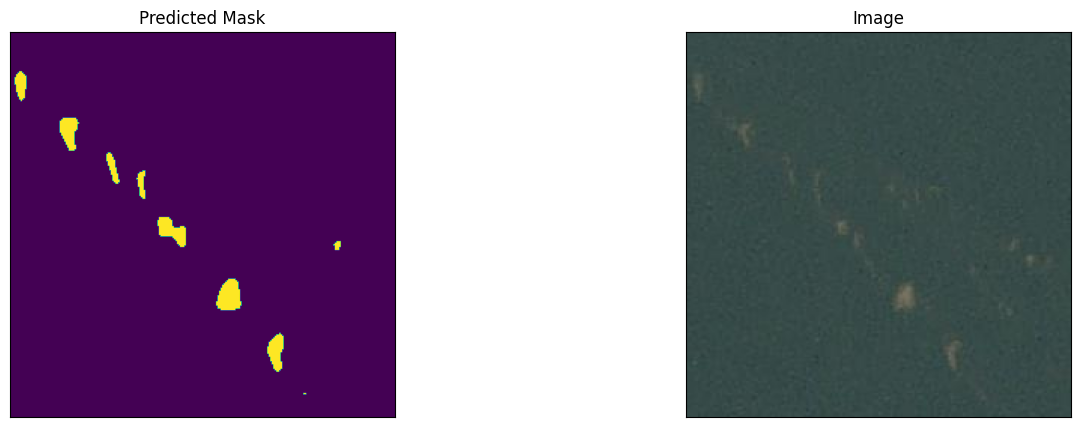

1/1 [==============================] - 0s 319ms/step


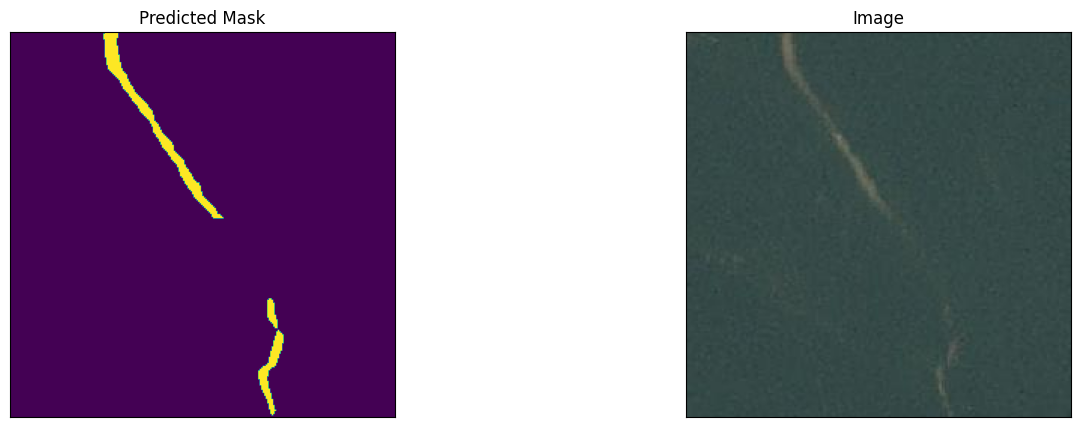

1/1 [==============================] - 0s 323ms/step


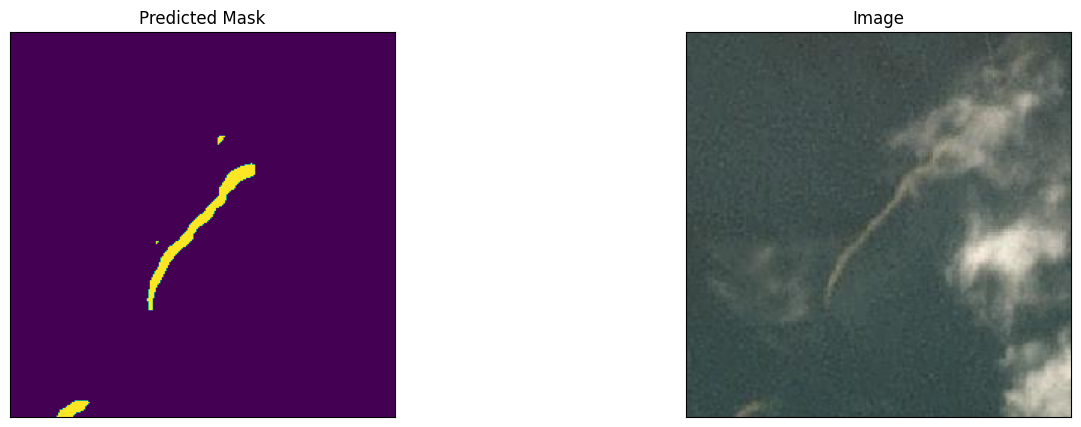

1/1 [==============================] - 0s 344ms/step


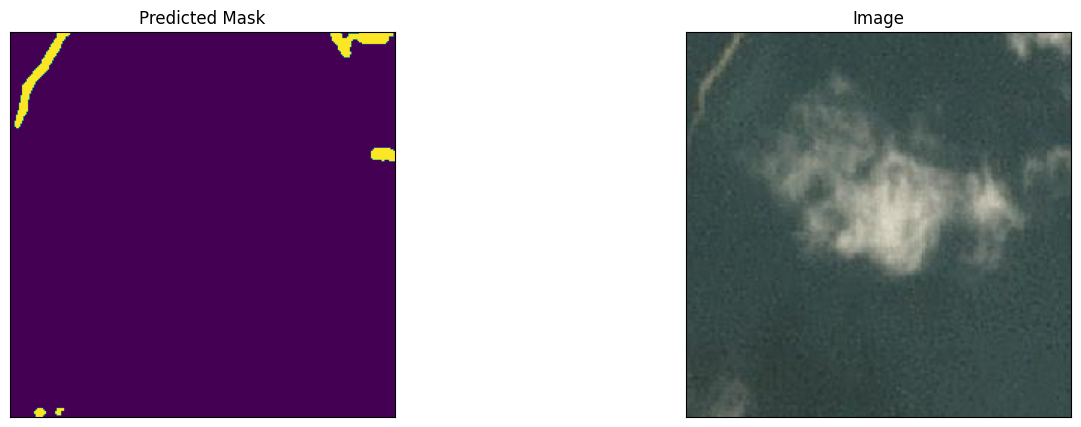

1/1 [==============================] - 0s 306ms/step


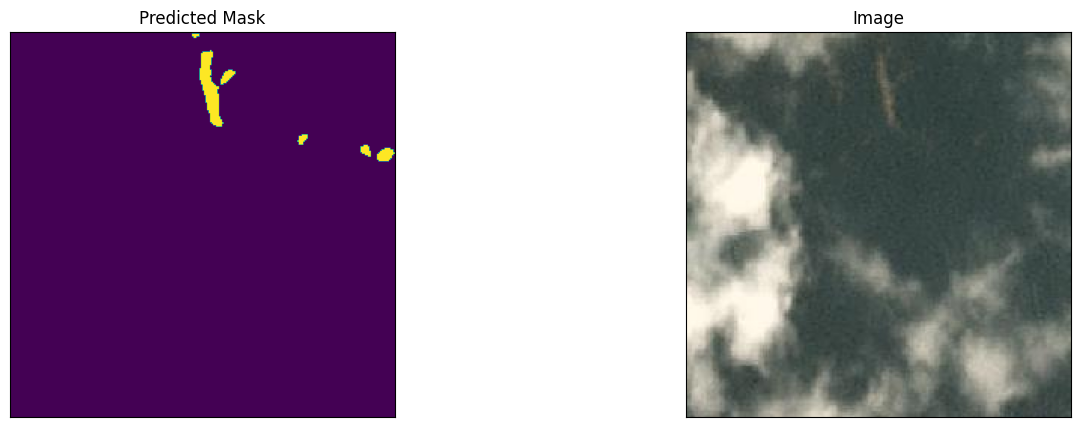

1/1 [==============================] - 0s 322ms/step


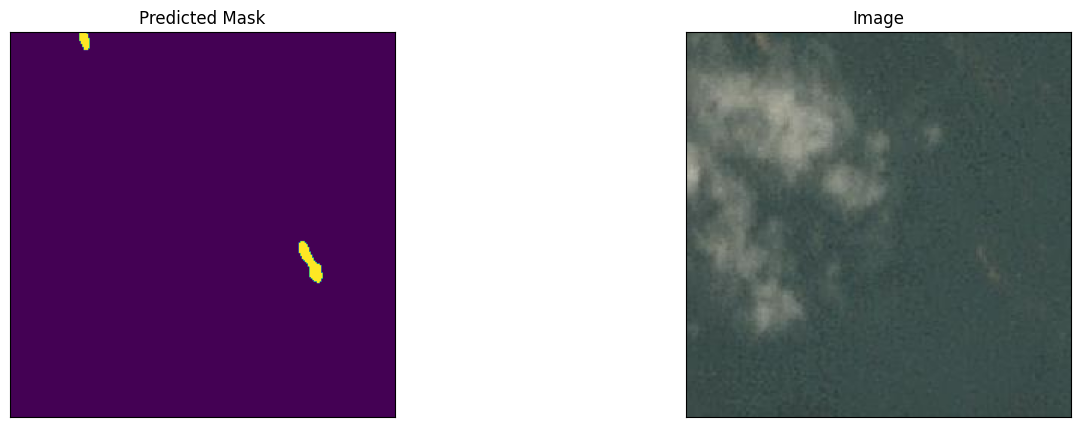

1/1 [==============================] - 0s 311ms/step


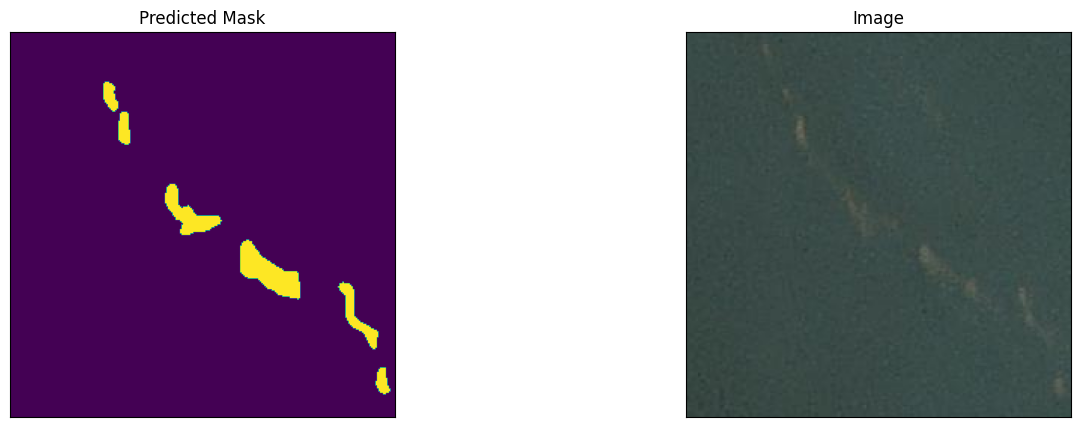

1/1 [==============================] - 0s 314ms/step


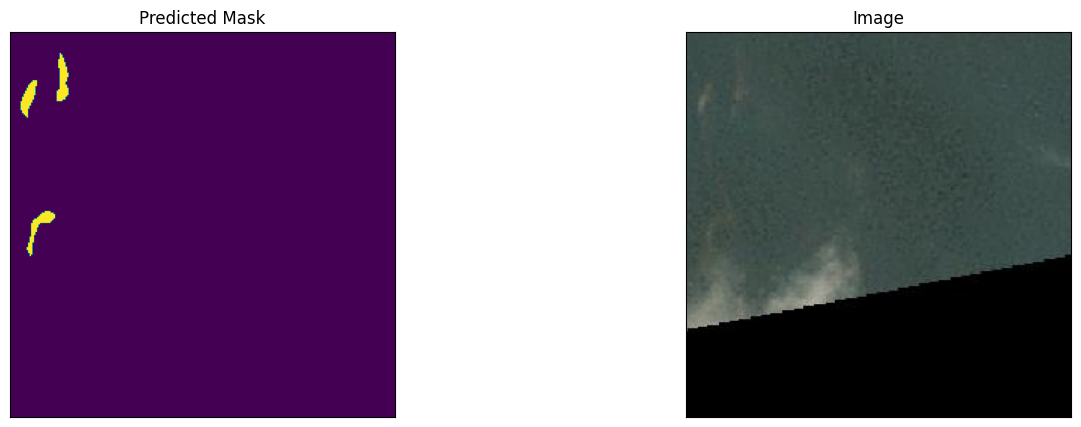

1/1 [==============================] - 0s 302ms/step


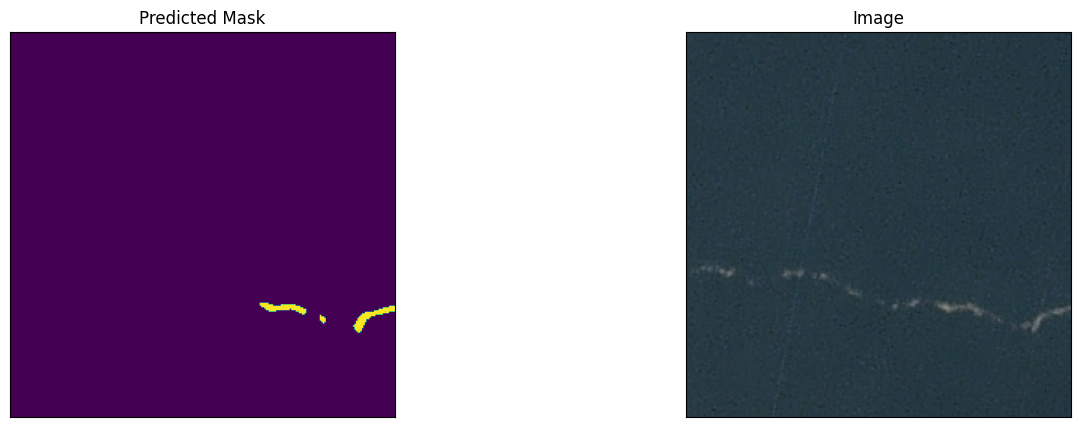

In [15]:
with tf.device("/GPU:0"):
    ## checking predictions on new unannotated images
    dataset_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/unannotated_images/"
    test_images = []
    for filename in os.listdir(dataset_dir):
        image_path = os.path.join(dataset_dir, filename)
        test_images.append(io.imread(image_path))

    for test_image in test_images:
        prediction = predict(model=model, image=test_image)
        visualize(
          predicted_mask=prediction,
          image=test_image
        )

1/1 [==============================] - 0s 413ms/step


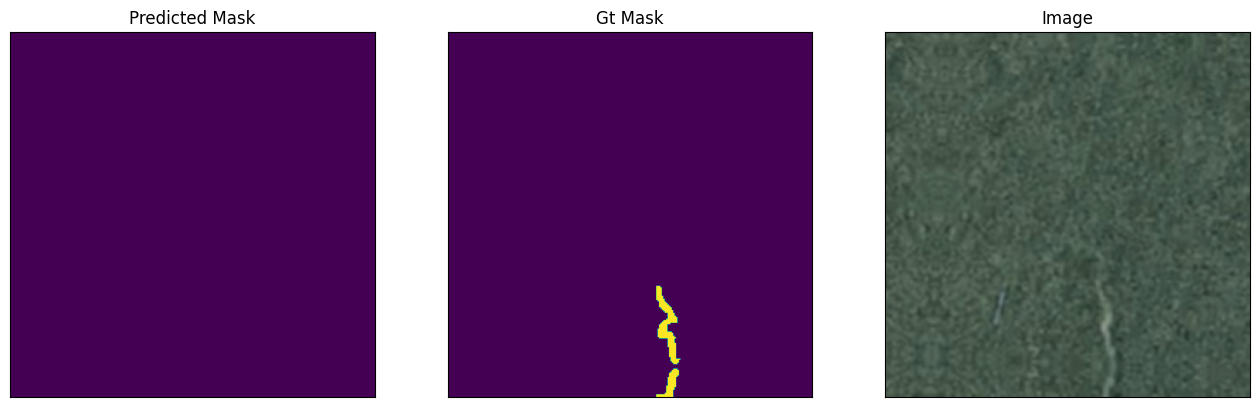

1/1 [==============================] - 0s 471ms/step


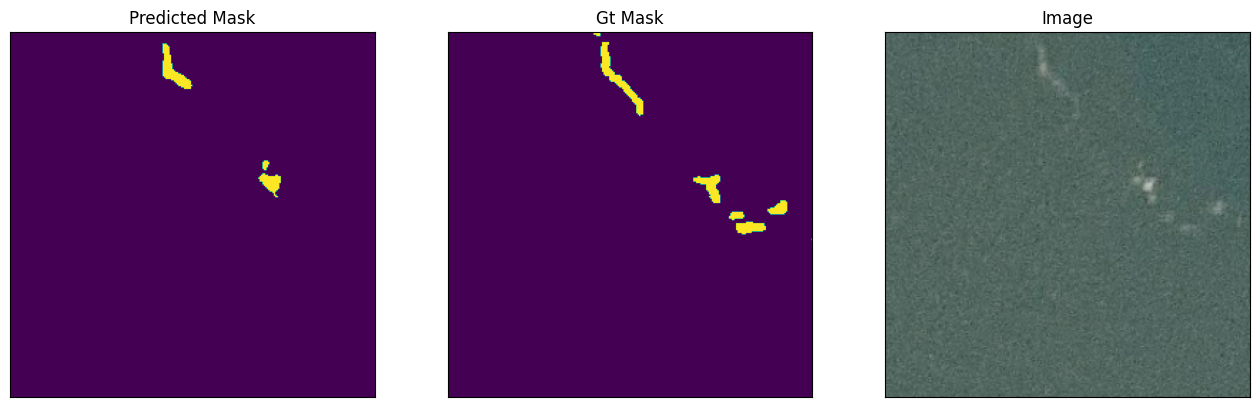

1/1 [==============================] - 0s 300ms/step


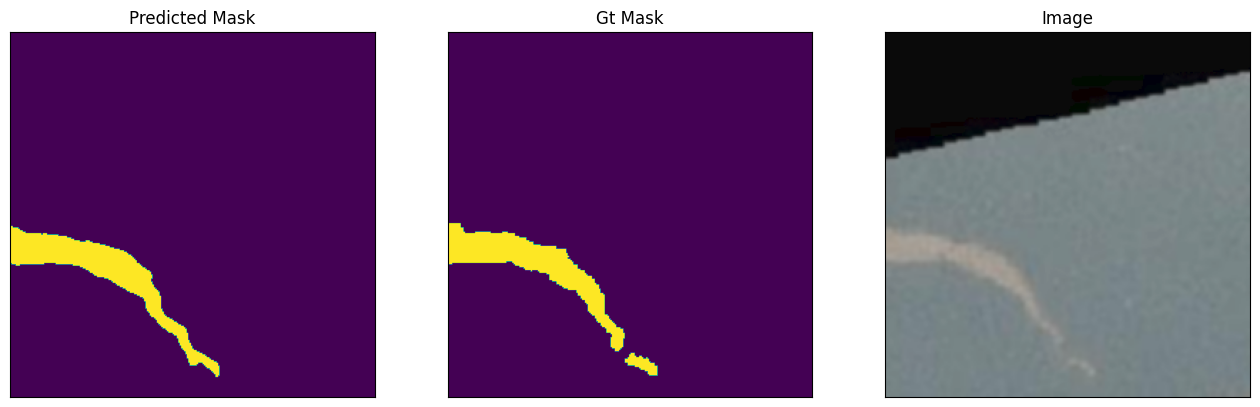

1/1 [==============================] - 0s 301ms/step


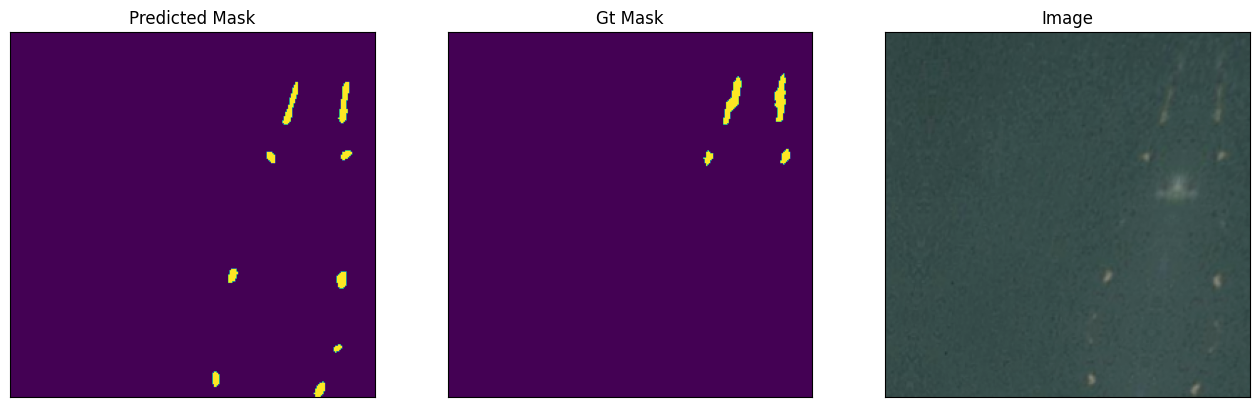

1/1 [==============================] - 0s 308ms/step


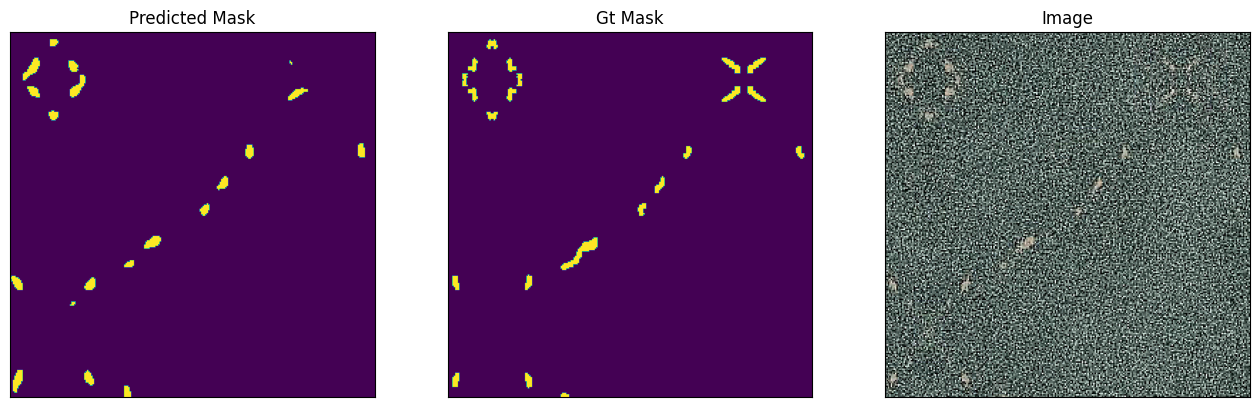

1/1 [==============================] - 0s 335ms/step


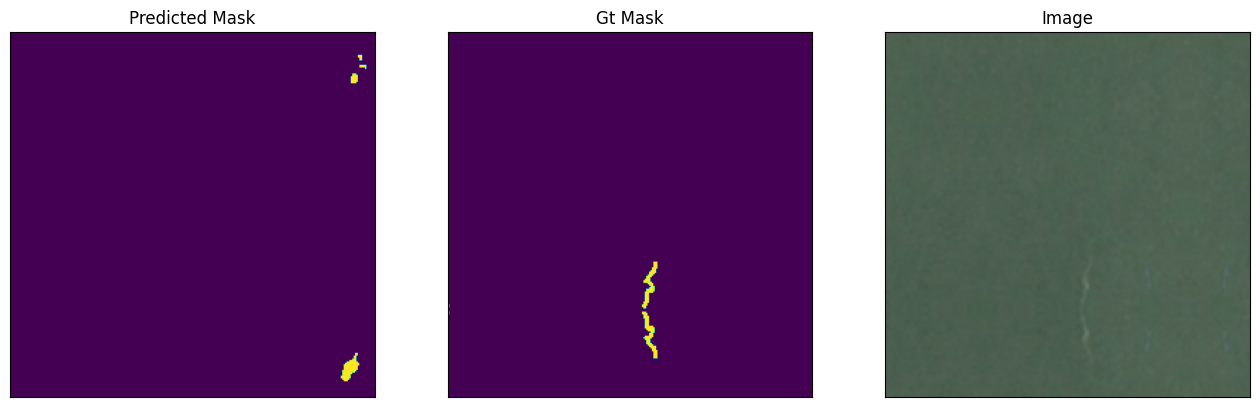

1/1 [==============================] - 0s 303ms/step


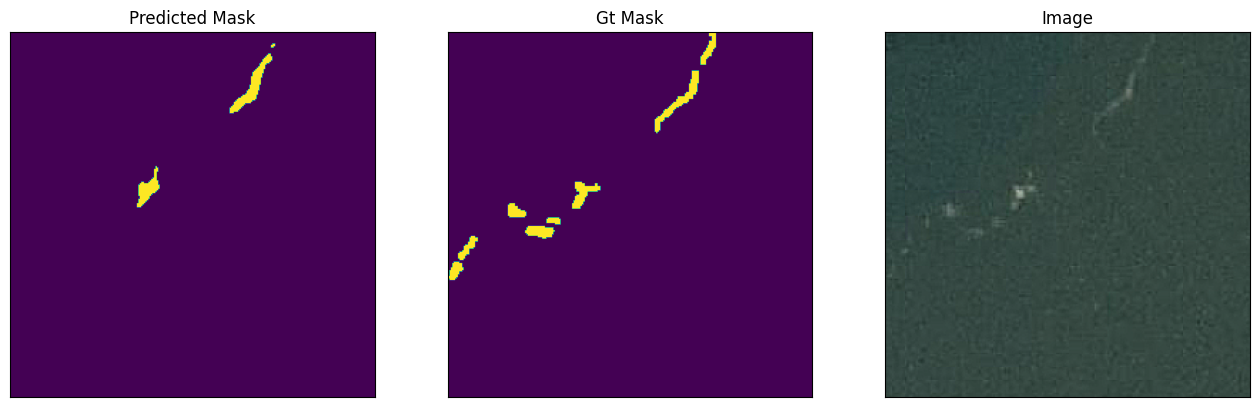

1/1 [==============================] - 0s 346ms/step


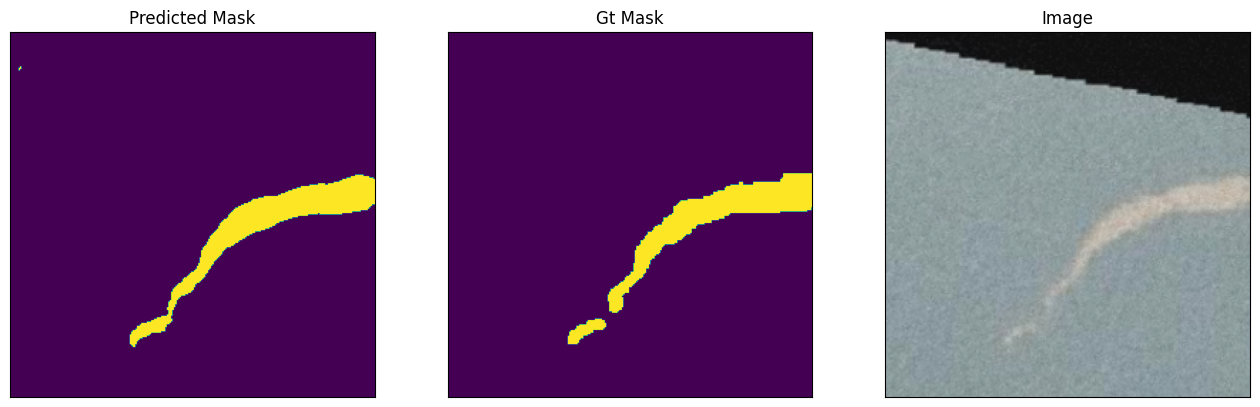

1/1 [==============================] - 0s 317ms/step


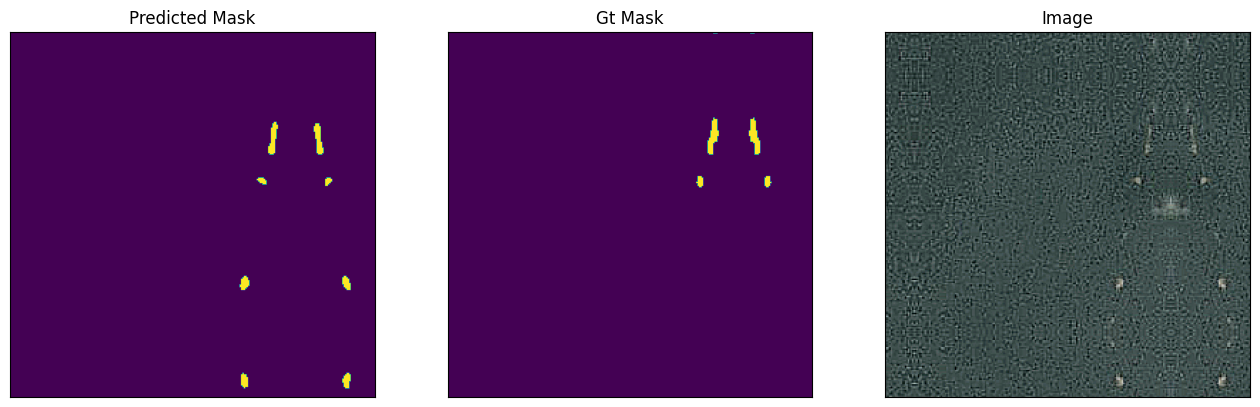

1/1 [==============================] - 0s 337ms/step


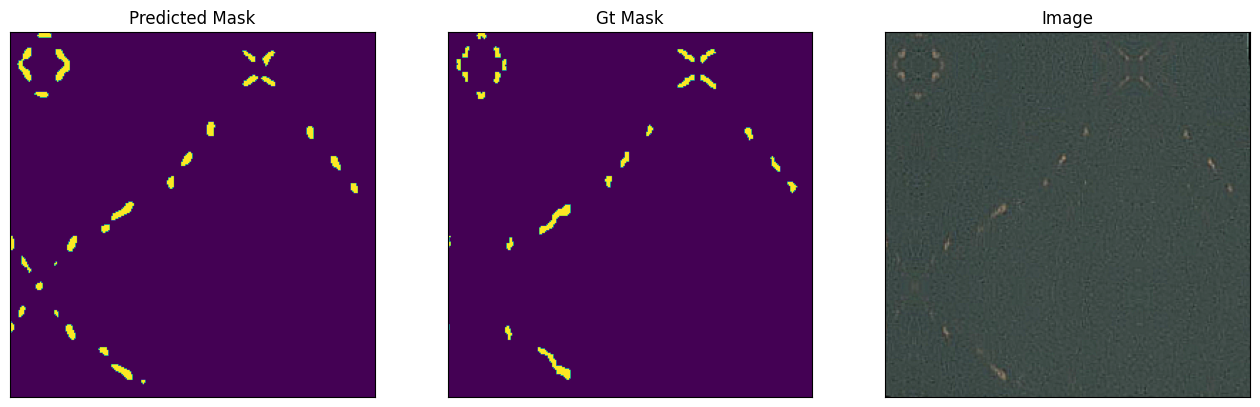

1/1 [==============================] - 0s 338ms/step


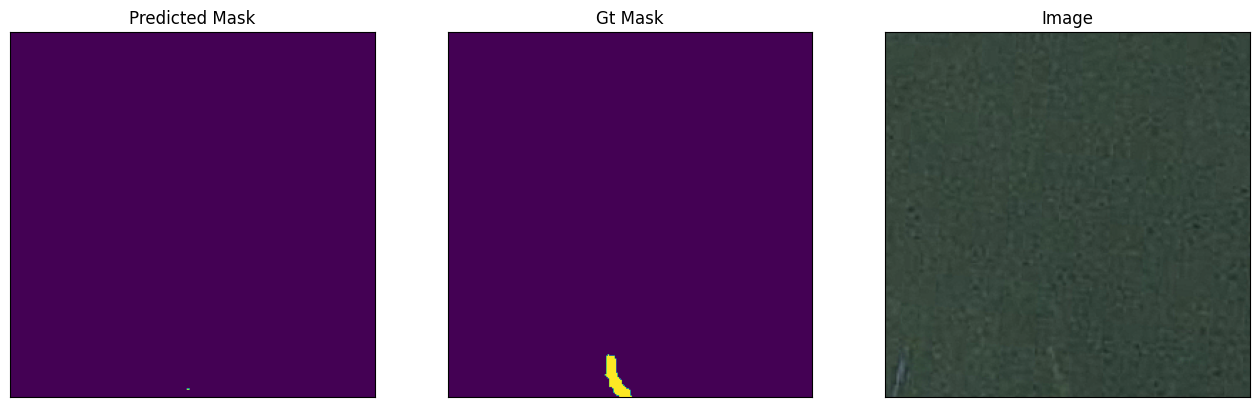

1/1 [==============================] - 0s 318ms/step


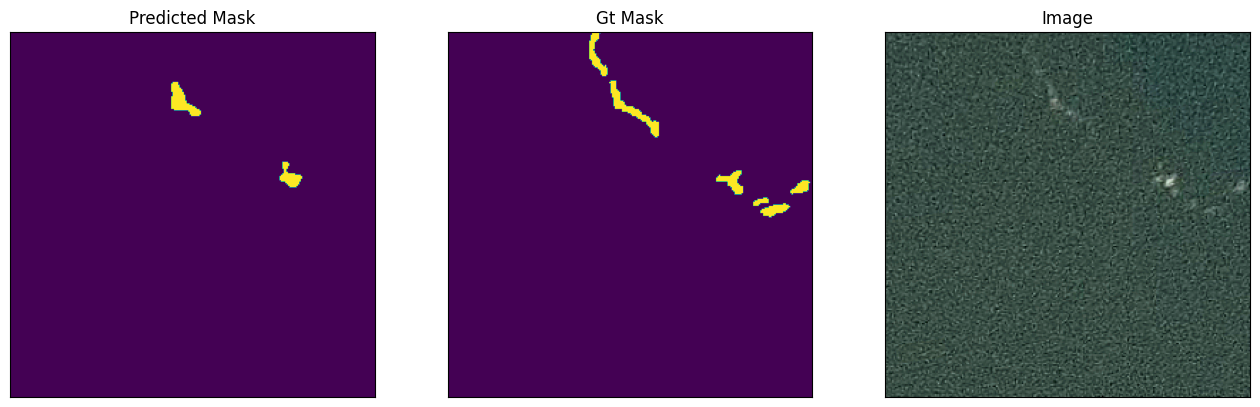

1/1 [==============================] - 0s 332ms/step


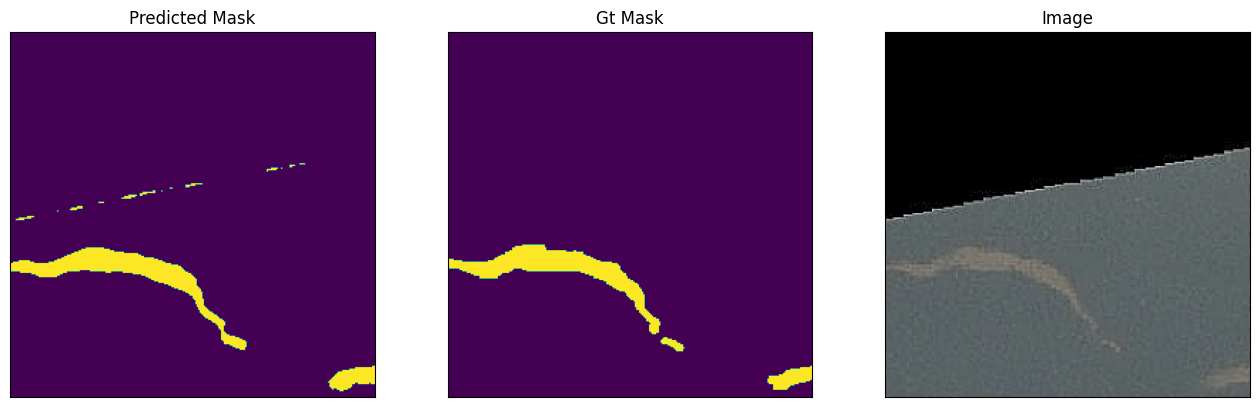

1/1 [==============================] - 0s 334ms/step


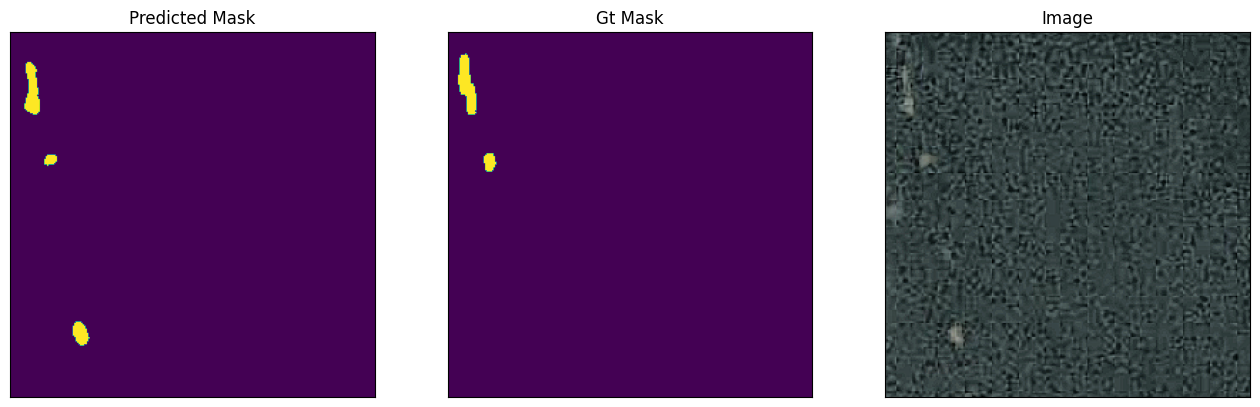

1/1 [==============================] - 0s 310ms/step


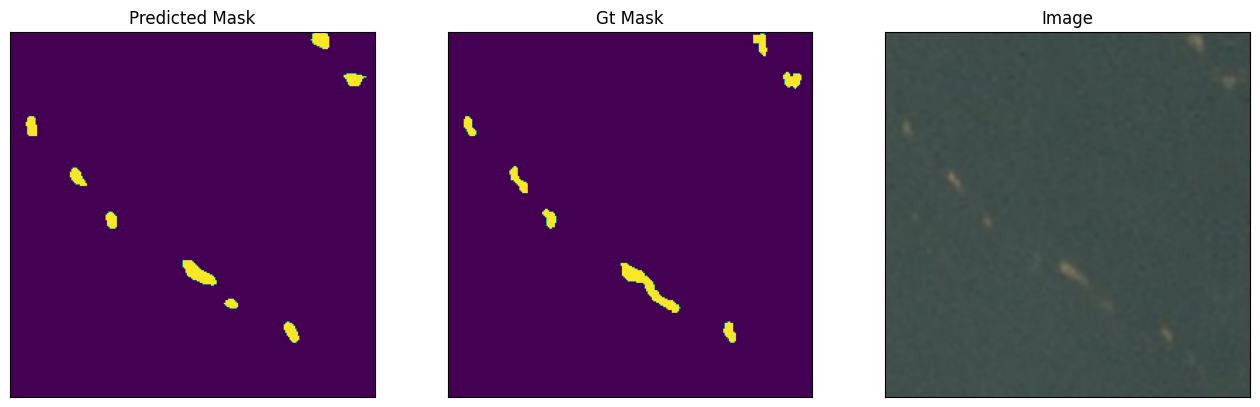

1/1 [==============================] - 0s 332ms/step


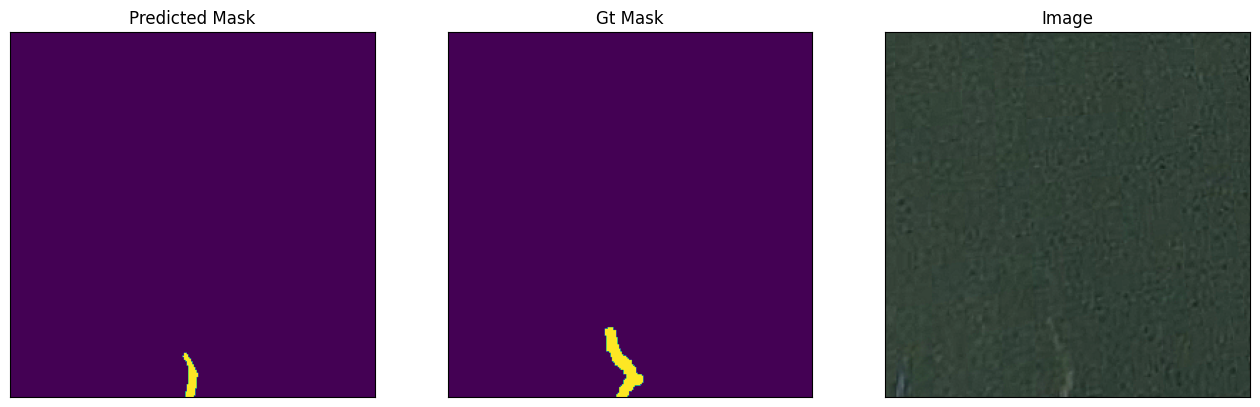

1/1 [==============================] - 0s 333ms/step


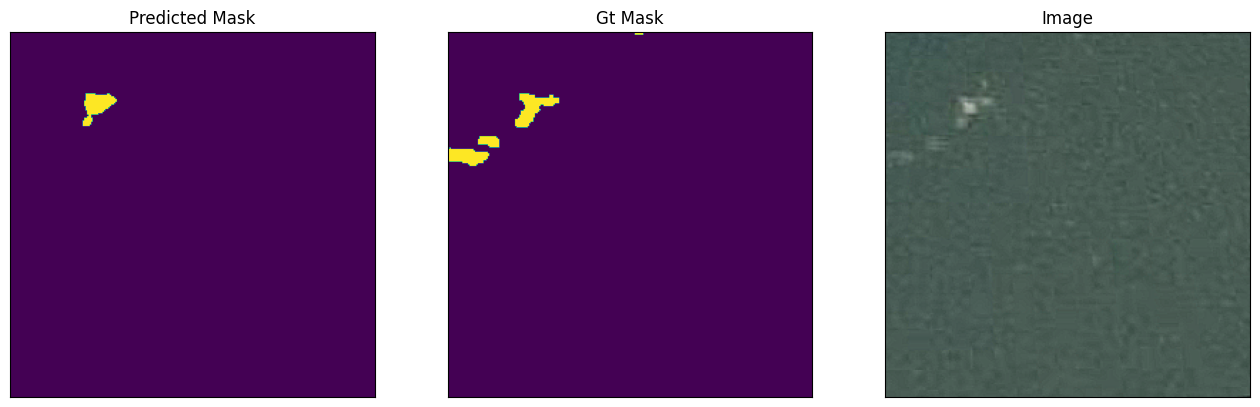

1/1 [==============================] - 0s 342ms/step


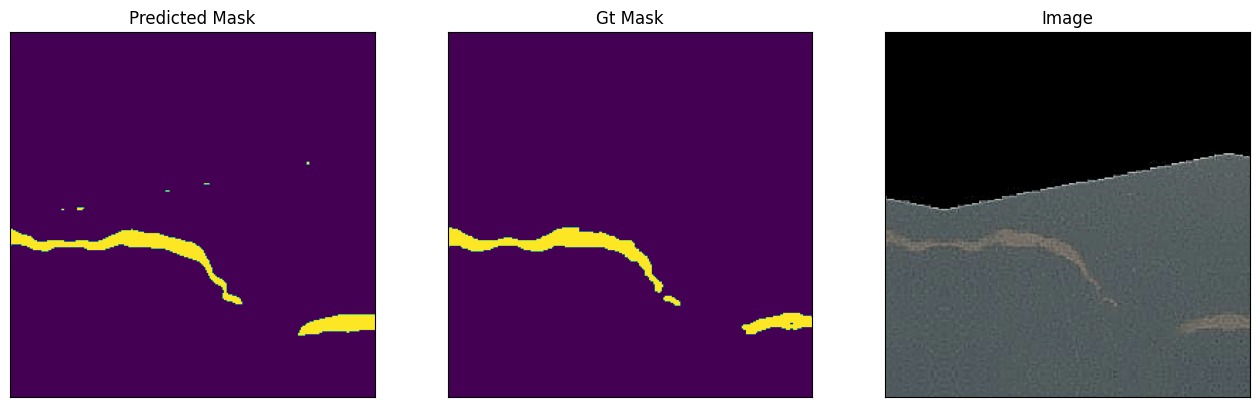

1/1 [==============================] - 0s 340ms/step


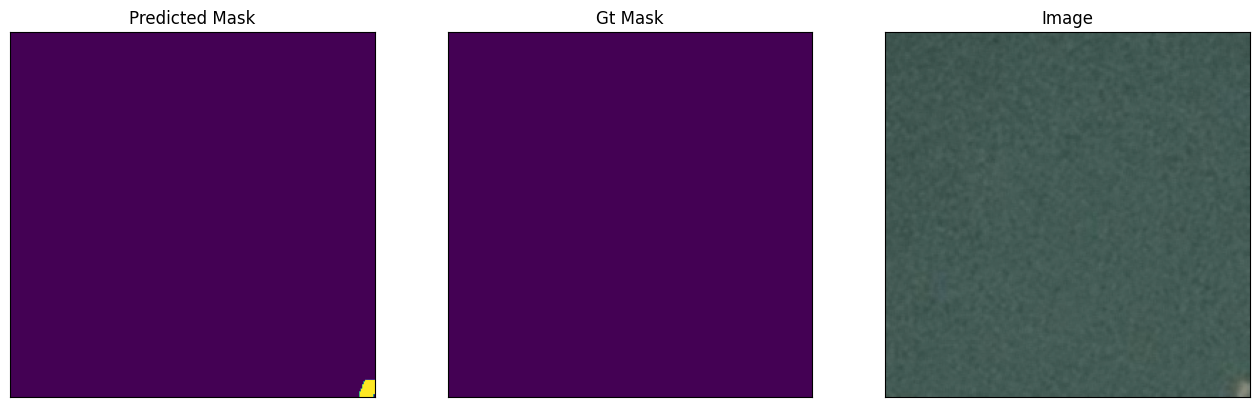

1/1 [==============================] - 0s 329ms/step


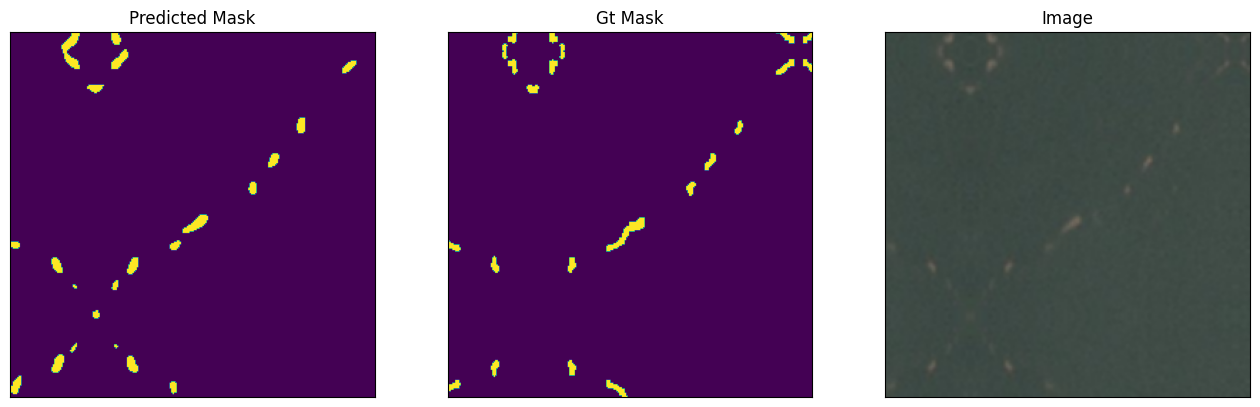

In [16]:
with tf.device('/GPU:0'):
    # checking few predictions from the valid dataset
    for i in range(100, 120):
      prediction = predict(model, valid_dataloader.dataset.x[i])
      visualize(
          predicted_mask=prediction,
          gt_mask=valid_dataloader.dataset.y[i],
          image=valid_dataloader.dataset.x[i]
      )